In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, LSTM, Dropout, Dense, Flatten, Input,  Embedding, Conv1D, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
airline_data = pd.read_csv("/gdrive/My Drive/datasets/airline_review.csv")
airline_data.head()



,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
airline_data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [0]:
X = airline_data["text"]

y = pd.get_dummies(airline_data.airline_sentiment, prefix='sent').values

In [6]:
y.shape

(14640, 3)

In [0]:
def clean_text(doc):

    document = remove_tags(doc)

    document = re.sub('[^a-zA-Z]', ' ', document)

    document = re.sub(r"\s+[a-zA-Z]\s+", ' ', document)

    document = re.sub(r'\s+', ' ', document)

    return document

In [0]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(document):
    return TAG_RE.sub('', document)

In [0]:
X_sentences = []
reviews = list(X)
for rev in reviews:
    X_sentences.append(clean_text(rev))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sentences, y, test_size=0.20, random_state=42)

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embedd_dict= dict()
glove_embeddings = open('/gdrive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8")


In [0]:
for embeddings in glove_embeddings:
    embedding_tokens = embeddings.split()
    emb_word = embedding_tokens [0]
    emb_vector = asarray(   embedding_tokens[1:], dtype='float32')
    embedd_dict [emb_word] = emb_vector 

glove_embeddings.close()

In [0]:
embedd_mat= zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embedd_dict.get(word)
    if embedding_vector is not None:
        embedd_mat[index] = embedding_vector

In [16]:
embedd_mat.shape

(12085, 100)

In [0]:
# embedding_inputs = Input(shape=(maxlen))
# embedding_layer = Embedding(vocab_size, 100, weights=[embedd_mat], trainable=False)(embedding_inputs )
# lstm1 = LSTM(500, activation='relu', return_sequences=True)(embedding_layer)

# lstm2 = LSTM(250, activation='relu', )(lstm1)

# dense1 = Dense(125, activation='relu')(lstm2)

# dense2 = Dense(50, activation='relu')(dense1)

# output_layer = Dense(y_train.shape[1], activation='softmax')(dense1)
# model = Model(embedding_inputs, output_layer)

In [0]:
embedding_inputs = Input(shape=(maxlen))
embedding_layer = Embedding(vocab_size, 100, weights=[embedd_mat], trainable=False)(embedding_inputs )
flatten_layer = Flatten()(embedding_layer)

dense1 = Dense(512, activation='relu')(flatten_layer)
do1 = Dropout(0.3)(dense1)

dense2 = Dense(512, activation='relu')(do1)
do2 = Dropout(0.3)(dense2)

dense3 = Dense(512, activation='relu')(do2)
do3 = Dropout(0.3)(dense3)

output_layer = Dense(y_train.shape[1], activation='softmax')(do3)
model = Model(embedding_inputs, output_layer)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

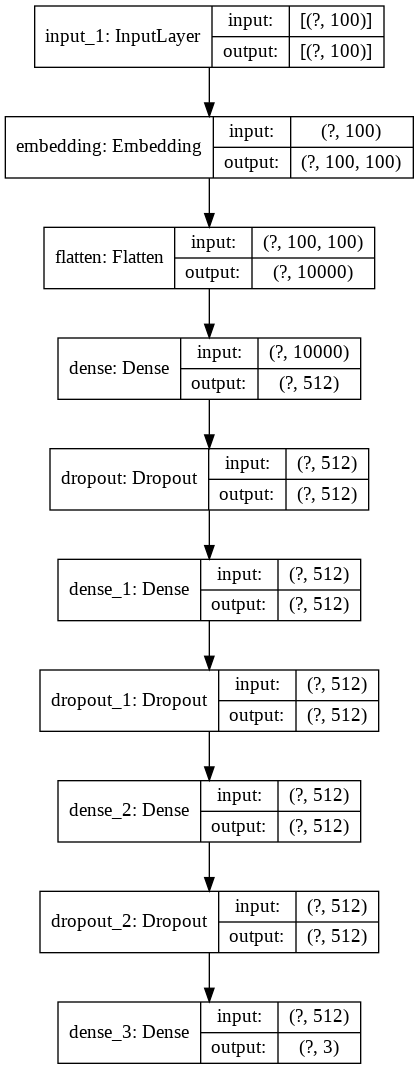

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [21]:
history = model.fit(X_train, y_train, batch_size= 64, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
147/147 [==============================] - 8s 55ms/step - loss: 0.7931 - accuracy: 0.6741 - val_loss: 0.6988 - val_accuracy: 0.7153
Epoch 2/10
147/147 [==============================] - 8s 54ms/step - loss: 0.6393 - accuracy: 0.7423 - val_loss: 0.6749 - val_accuracy: 0.7354
Epoch 3/10
147/147 [==============================] - 8s 54ms/step - loss: 0.5545 - accuracy: 0.7766 - val_loss: 0.6577 - val_accuracy: 0.7375
Epoch 4/10
147/147 [==============================] - 8s 54ms/step - loss: 0.4669 - accuracy: 0.8176 - val_loss: 0.6873 - val_accuracy: 0.7431
Epoch 5/10
147/147 [==============================] - 8s 54ms/step - loss: 0.3946 - accuracy: 0.8480 - val_loss: 0.7632 - val_accuracy: 0.7153
Epoch 6/10
147/147 [==============================] - 8s 54ms/step - loss: 0.3219 - accuracy: 0.8763 - val_loss: 0.7930 - val_accuracy: 0.7341
Epoch 7/10
147/147 [==============================] - 8s 54ms/step - loss: 0.2524 - accuracy: 0.9012 - val_loss: 1.0018 - val_accuracy: 0.7200

In [22]:
print(score[0])
print(score[1])

1.084073543548584
0.7407786846160889
